In [1]:
# because of version problems,
# Jupyter notebook prints too many warning messsage
# This parts helps to ignore these warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%pwd

'/home/qiao/dev/giao/havingfun/detecting/segmentation/unet34'

In [4]:
print(torch.cuda.is_available())

True


In [5]:
path = Path('/home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613')

path_img = path/'imgs/'
path_label = path/'labels'
codes = ['Smoke', 'Flame', 'Background']
path_img

Path('/home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/imgs')

In [6]:
fnames = get_image_files(path_img)
print('======> example of training image', fnames[0])
lbl_names = get_image_files(path_label)
print('======> example of training label', lbl_names[0])

======> example of training image /home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/imgs/M300_20220613_41.2_13.png
======> example of training label /home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/labels/label_M300_20220613_41.2_31.png


In [7]:
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

In [8]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 4,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((385, 480))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

For fastai, the evaluation ratios include:  
```
__all__ = ['error_rate', 'accuracy', 'accuracy_thresh', 'dice', 'exp_rmspe', 'fbeta','FBeta', 'mse', 'mean_squared_error',
           'mae', 'mean_absolute_error', 'rmse', 'root_mean_squared_error', 'msle', 'mean_squared_logarithmic_error',
           'explained_variance', 'r2_score', 'top_k_accuracy', 'KappaScore', 'ConfusionMatrix', 'MatthewsCorreff',
           'Precision', 'Recall', 'R2Score', 'ExplainedVariance', 'ExpRMSPE', 'RMSE', 'Perplexity', 'AUROC', 'auc_roc_score', 
           'roc_curve', 'MultiLabelFbeta', 'foreground_acc']
```

In [9]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

# metrics = acc_smoke

In [10]:
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# original, pixel level accuracy
def pixel_accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

# auc: area under the curve, a general computing using the trapezoidal rule.
# roc_curve: Receiver operating characteristic (ROC); xlabel: false positve; ylabel: true positive
# roc_auc_score: area under the receiver operating characteristic curve
def auc_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    Auc_score = roc_auc_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), multi_class='ovr')
    return Auc_score

# f1-score
def f1_score_macro(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    F1 = f1_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), average = 'macro') # , average = 'macro'
    return F1

# average precision score: area under the precision-recal curve
def precision_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # for multilabel-indicator, `pos_label` is fixed to 1.
    precision_score = average_precision_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu())
    return precision_score

# metrics = evaluate_acc
metrics = [pixel_accuracy, auc_score, precision_score, f1_score_macro]
# metrics = roc_curve
# metrics = evaluate_ap

In [11]:
# callback metrics works for CNN-learner
# but it seems strange for such dynamic U-net
callback_fns = [Precision, Recall, FBeta(average = 'macro', beta = 3.)]

In [12]:
# using original resnet34-based U-net, therefore no `attention`
learn = unet_learner(dls, models.resnet34, metrics = metrics, self_attention=True)

In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [14]:
# using the pretrained params --- go as a transfer learning
learn.load('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/models/u34unfreeze_att_step1_20220711')

SuggestedLRs(valley=3.630780702224001e-05)

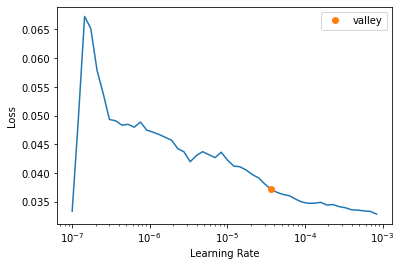

In [17]:
learn.lr_find()

In [18]:
lr = 3.63e-5
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,precision_score,f1_score_macro,time
0,0.040718,0.021282,0.992960,0.728503,0.340217,0.515964,00:21
1,0.028383,0.016250,0.993938,0.796840,0.460581,0.549463,00:19
2,0.022070,0.015298,0.994127,0.872501,0.522015,0.566806,00:19
3,0.018458,0.014347,0.994507,0.843826,0.525907,0.567625,00:19
4,0.015929,0.017120,0.994143,0.827849,0.500398,0.558481,00:19
5,0.014255,0.018370,0.994139,0.803973,0.486902,0.552982,00:19
6,0.012999,0.015754,0.994485,0.846667,0.527077,0.567510,00:19
7,0.011991,0.016294,0.994446,0.840249,0.522555,0.565715,00:19
8,0.011340,0.015685,0.994484,0.856199,0.533914,0.569883,00:19
9,0.010876,0.015951,0.994491,0.854402,0.534046,0.569765,00:19


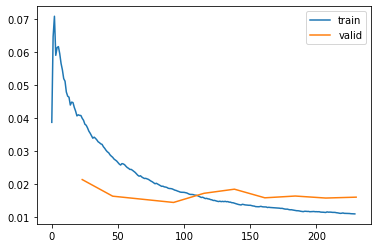

In [19]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [20]:
learn.save('u34freeze_att_step2_20220711')
learn.load('u34freeze_att_step2_20220711')

SuggestedLRs(valley=9.999999747378752e-06)

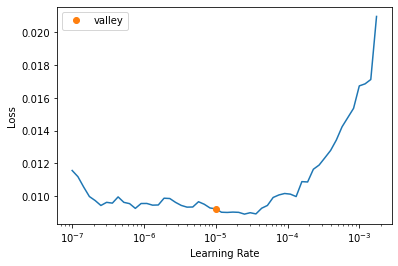

In [23]:
learn.unfreeze()
learn.lr_find()

In [24]:
lr_max = 9.99e-6

In [25]:
learn.fit_one_cycle(4, lr_max)

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,precision_score,f1_score_macro,time
0,0.009932,0.015906,0.994238,0.893408,0.550483,0.575111,00:21
1,0.010209,0.016604,0.994324,0.867194,0.541688,0.572804,00:20
2,0.010051,0.016016,0.994618,0.848672,0.546528,0.572691,00:20
3,0.009603,0.015204,0.994636,0.863452,0.554626,0.575711,00:20


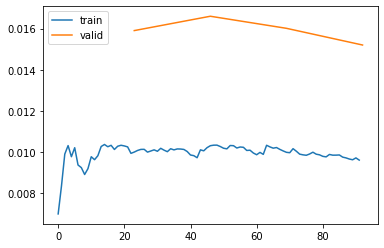

In [26]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/imgs/models/u34unfreeze_att_step2_20220711.pth')

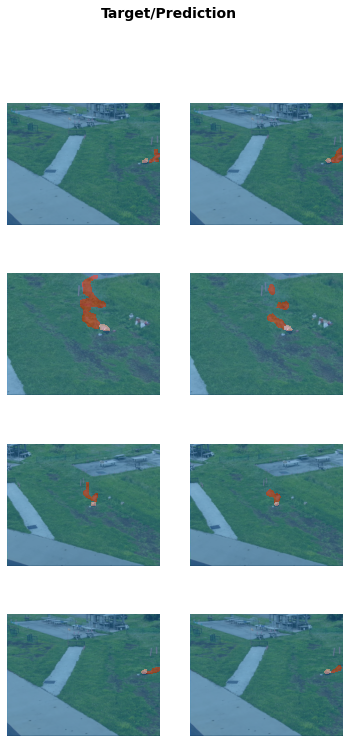

In [27]:
learn.show_results()
learn.save('u34unfreeze_att_step2_20220711')

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [19]:
img = Image.open('/home/qiao/dev/giao/datasets/test_youtube/test_save_youtube_0.png').resize((480, 385))
img.show()

In [15]:
img = PILImage(img)
print(img)

PILImage mode=RGB size=480x385


In [16]:
learn.load('pretrained20220613-f')
# learn.load('attunet')

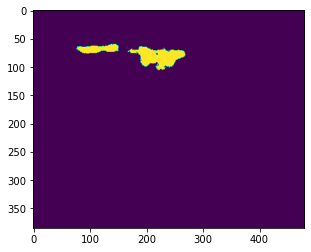

In [17]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

In [18]:
# one time test
import cv2
import numpy as np
from PIL import Image

img = cv2.imread('/home/qiao/dev/giao/datasets/bounding/images/DJI_20211017111122_0003_Z_MP4_1.png')

# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pilimgimg = Image.fromarray(img).resize((480, 385))
img_pil = PILImage(im_pilimgimg)
img_pil.show()

[ WARN:0@0.015] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/qiao/dev/giao/datasets/bounding/images/DJI_20211017111122_0003_Z_MP4_1.png'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
prediction_mask = learn.predict(img_pil)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

## In this work, transfer learning idea is used and we used the pretrained parameters and slightly trained for more steps with the new dataset.
## The results are pretty well, accuracy even reached 99.487%